## Assignment 3 Task: Recurrent Neural Networks for Stock Price Prediction

#### Md Tauhidul Islam
` University of Adelaide`
` Adelaide SA 5005`
` a1895813@adelaide.edu.au`

#### 1.0 Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, SimpleRNN, LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.regularizers import l2

# Seting seeds for reproducibility

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

#### 2.0 Loading and Inspecting Dataset

In [2]:
# Loading training and testing datasets
google_training_set = pd.read_csv('Google_Stock_Price_Train.csv')
google_test_set = pd.read_csv('Google_Stock_Price_Test.csv')

# Displayin the data
print("Training Data:\n")
print(google_training_set.head())

print("\nTesting Data:\n")
print(google_test_set.head())

Training Data:

       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

Testing Data:

       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400


In [3]:
# Checking data types
print("\nTraining Data Type\n:")
print(google_training_set.dtypes)

# Checking data info
print("\nTraining Data Info:\n")
google_training_set.info()

print("\nTesting Data Info:\n")
google_test_set.info()


Training Data Type
:
Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

Training Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB

Testing Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float

#### 3.0 Preprocessing

In [4]:
#Checkin null value in train data
google_training_set.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [5]:
#Checkin null value in test data
google_test_set.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

*Findings: No null values in our dataset*

###### Cleaning and Scaling

In [6]:
# We now want to remove "," from the data in order to convert into numeric format
for i in ['Open', 'High', 'Low', 'Close', 'Volume']:
    google_training_set[i] = google_training_set[i].astype(str).str.replace(',', '').astype(float)
    google_test_set[i] = google_test_set[i].astype(str).str.replace(',', '').astype(float)

# Scaleing the data with min-max scaler
scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Close', 'Volume']

scaled_training_set = scaler.fit_transform(google_training_set[features])
scaled_test_set = scaler.transform(google_test_set[features])

In [7]:
print(f"\nNumber of rows in train data: {len(google_training_set)}\n")
print(f"Number of rows in test data: {len(scaled_test_set)}")


Number of rows in train data: 1258

Number of rows in test data: 20


###### Createing sequences

In [8]:
# Function to create sequences for time series prediction
def create_sequences(dataset, steps_num):
    X, y = [], []
    for i in range(len(dataset) - steps_num):
        X.append(dataset[i:i+steps_num])
        y.append(dataset[i+steps_num, :5])  # Predict next day's open, high, low, close
    return np.array(X), np.array(y)

# We are defining sequence length (N=15) since we only have 20 observations in test data. N needs to be less than 20.
N = 15

# Spliting scaled train data into training and validation sets (80-20 split)
spliting_index = int(0.8 * len(scaled_training_set))
training_set = scaled_training_set[:spliting_index]  # 80% for training
validation_set = scaled_training_set[spliting_index:]         # 20% for validation

# Creating sequences for training and validation sets
X_train, y_train = create_sequences(training_set, N)
X_val, y_val = create_sequences(validation_set, N)

# Creating sequences for testing data
X_test, y_test = create_sequences(scaled_test_set, N)

#  Shapes of the datasets
print(f"Shape of Training Set: {X_train.shape}, {y_train.shape}")
print(f"Shape of Validation Set: {X_val.shape}, {y_val.shape}")
print(f"Shape of Test Set: {X_test.shape}, {y_test.shape}")


Shape of Training Set: (991, 15, 5), (991, 5)
Shape of Validation Set: (237, 15, 5), (237, 5)
Shape of Test Set: (5, 15, 5), (5, 5)


#### 3.0 Model Desing

##### 3.1 Vanilla RNN Model

In [9]:
# Defining Vanilla RNN model
vanilla_rnn_model = Sequential([
    SimpleRNN(50, return_sequences=True, input_shape=(N, 5),
    kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    SimpleRNN(50),
    Dropout(0.2),
    Dense(5)
])

# Compiling the model
vanilla_rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
vanilla_rnn_model.summary()


# Training the Vanilla RNN model
history_rnn_model = vanilla_rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 15, 50)              │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,105 (31.66 KB)

 Trainable params: 8,105 (31.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2534 - val_loss: 0.0285
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0920 - val_loss: 0.0241
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0564 - val_loss: 0.0108
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0432 - val_loss: 0.0102
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0353 - val_loss: 0.0095
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0298 - val_loss: 0.0111
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0265 - val_loss: 0.0103
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0236 - val_loss: 0.0094
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0224 - val_loss: 0.0106
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0210 - val_loss: 0.0080
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - val_loss: 0.0079
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - val_l

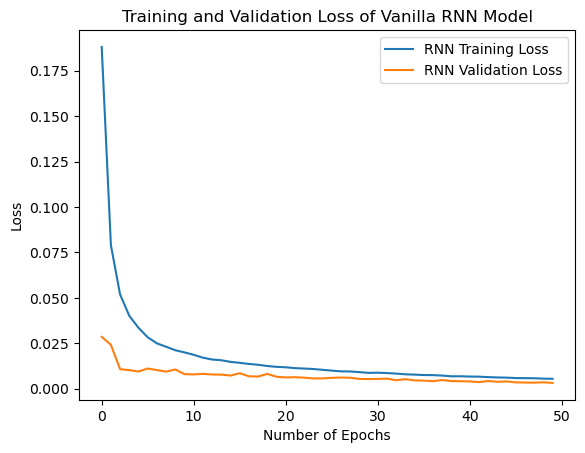

In [10]:
# Trainig and validation loss for Vanilla RNN model
plt.plot(history_rnn_model.history['loss'], label='RNN Training Loss')
plt.plot(history_rnn_model.history['val_loss'], label='RNN Validation Loss')

plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of Vanilla RNN Model')
plt.show()


##### 3.2 GRU Model

In [11]:
# Defining GRU model
gru_model = Sequential([
    GRU(50, return_sequences=True, input_shape=(N, 5),
    kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(5)
])

# Compiling the GRU model
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
gru_model.summary()

# Training the GRU model
gru_history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 15, 50)              │           8,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 15, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,105 (94.16 KB)

 Trainable params: 24,105 (94.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0922 - val_loss: 0.0333
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0187 - val_loss: 0.0106
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - val_loss: 0.0065
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - val_loss: 0.0050
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 - val_loss: 0.0044
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0095 - val_loss: 0.0046
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0085 - val_loss: 0.0036
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 - val_loss: 0.0038
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - val_loss: 0.0038
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - val_loss: 0.0045
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - val_loss: 0.0035
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - val_l

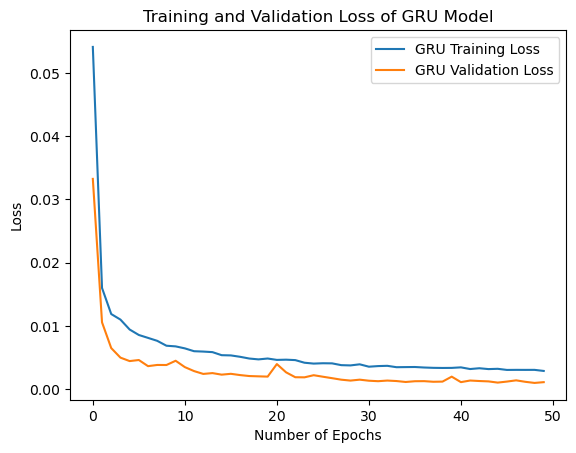

In [12]:
plt.plot(gru_history.history['loss'], label='GRU Training Loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation Loss')

plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of GRU Model')
plt.show()


##### 3.3 LSTM Model

In [13]:
# Defining LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(N, 5),
    kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(5)
])

# Compiling the LSTM model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
lstm_model.summary()

# Training the LSTM model
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 15, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 15, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             255 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,655 (123.65 KB)

 Trainable params: 31,655 (123.65 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0818 - val_loss: 0.0312
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0201 - val_loss: 0.0108
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0144 - val_loss: 0.0094
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0124 - val_loss: 0.0057
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0109 - val_loss: 0.0056
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - val_loss: 0.0061
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - val_loss: 0.0042
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - val_loss: 0.0033
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - val_loss: 0.0040
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - val_loss: 0.0041
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - val_loss: 0.0033
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - val_l

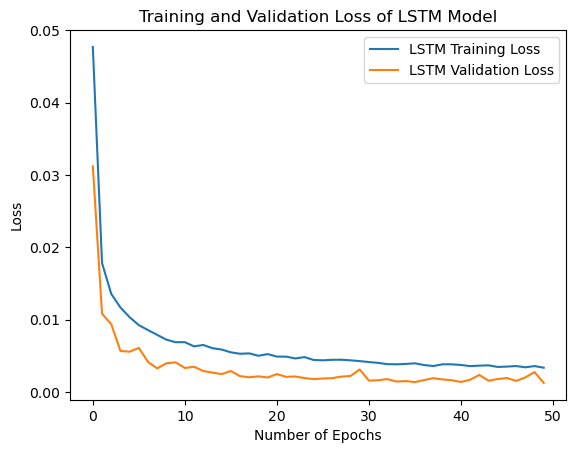

In [14]:
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')

plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss of LSTM Model')
plt.show()


#### 4.0 Model Evaluation

In [15]:
# Evaluating models on test set
rnn_test_loss = vanilla_rnn_model.evaluate(X_test, y_test, verbose=0)
gru_test_loss = gru_model.evaluate(X_test, y_test, verbose=0)
lstm_test_loss = lstm_model.evaluate(X_test, y_test, verbose=0)

print(f"RNN Test Loss: {rnn_test_loss:.5f}")
print(f"GRU Test Loss: {gru_test_loss:.5f}")
print(f"LSTM Test Loss: {lstm_test_loss:.5f}")


RNN Test Loss: 0.00414
GRU Test Loss: 0.00201
LSTM Test Loss: 0.00207


In [16]:
# Predictions on the test set
rnn_pred = vanilla_rnn_model.predict(X_test)
gru_pred = gru_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)

# Calculating metrics for each model
rnn_mse = mean_squared_error(y_test, rnn_pred)
gru_mse = mean_squared_error(y_test, gru_pred)
lstm_mse = mean_squared_error(y_test, lstm_pred)

rnn_mape = mean_absolute_percentage_error(y_test, rnn_pred)
gru_mape = mean_absolute_percentage_error(y_test, gru_pred)
lstm_mape = mean_absolute_percentage_error(y_test, lstm_pred)


print(f"RNN Test MSE: {rnn_mse:.5f}, Test MAPE: {rnn_mape:.5f}")
print(f"GRU Test MSE: {gru_mse:.5f}, Test MAPE: {gru_mape:.5f}")
print(f"LSTM Test MSE: {lstm_mse:.5f}, Test MAPE: {lstm_mape:.5f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
RNN Test MSE: 0.00174, Test MAPE: 0.11227
GRU Test MSE: 0.00168, Test MAPE: 0.13197
LSTM Test MSE: 0.00175, Test MAPE: 0.10382


#### 5.0 Visualisation of Actual and Predcited Open Price

##### 5.1 Plot for RNN

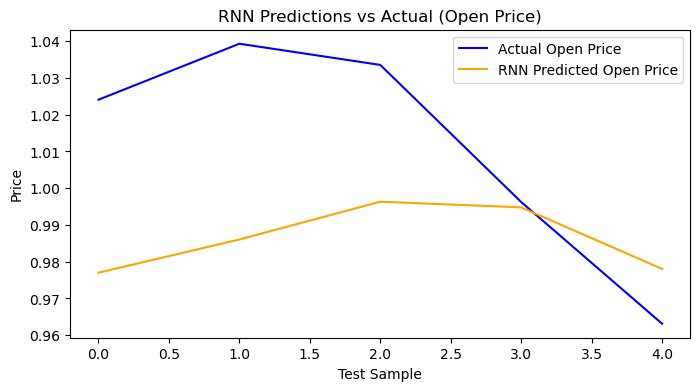

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(y_test[:, 0], label='Actual Open Price', color='blue')  # Actual
plt.plot(rnn_pred[:, 0], label='RNN Predicted Open Price', color='orange')  # Predicted
plt.title('RNN Predictions vs Actual (Open Price)')
plt.xlabel('Test Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

##### 5.2 Plot for GRU

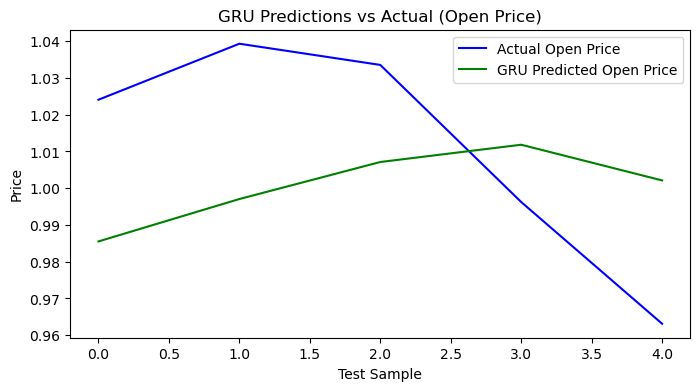

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(y_test[:, 0], label='Actual Open Price', color='blue')
plt.plot(gru_pred[:, 0], label='GRU Predicted Open Price', color='green')
plt.title('GRU Predictions vs Actual (Open Price)')
plt.xlabel('Test Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

##### 5.3 Plot for LSTM

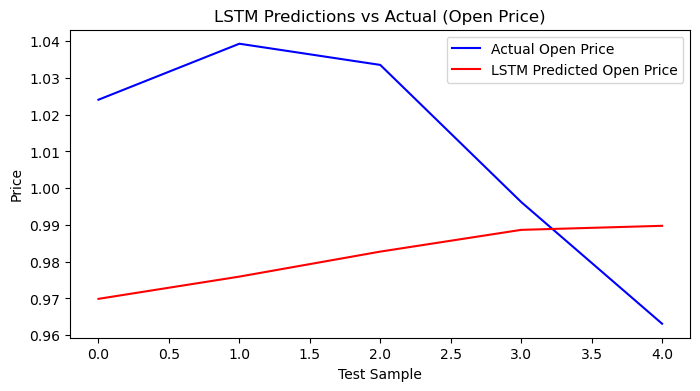

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(y_test[:, 0], label='Actual Open Price', color='blue')
plt.plot(lstm_pred[:, 0], label='LSTM Predicted Open Price', color='red')
plt.title('LSTM Predictions vs Actual (Open Price)')
plt.xlabel('Test Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

*Model Selection: GRU shows the lowest MSE which indicates better performance among all models.
Therefore, we'll be selecting the GRU model and tune the hyperparameter to get the best possible output*

#### 6.0 Hyperparameter Tuning

##### 6.1 Tuning for Layers of GRU

In [20]:
# Testing single and stacked RNN layers to find out which to use
for layers in [1, 2]:
    model = Sequential()
    if layers == 1:
        model.add(GRU(50, return_sequences=False, input_shape=(N, 5),
    kernel_regularizer=l2(0.001)))
    else:
        model.add(GRU(50, return_sequences=True, input_shape=(N, 5),
    kernel_regularizer=l2(0.001)))
        model.add(GRU(50, return_sequences=False,
    kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(5))  # Output: Open, High, Low, Close, Volume
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        verbose=0
    )
    val_loss = history.history['val_loss'][-1]
    print(f"Layers: {layers}, Validation Loss: {val_loss:.5f}")


C:\Users\User\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Layers: 1, Validation Loss: 0.00243
Layers: 2, Validation Loss: 0.00434


*Summary: Since the GRU with 1 layer shows less validation loss, we'll be proceeding with single layer GRU model*

##### 6.2 Tuning for the Best Number of Units

In [21]:
units_results = {}

for units in [50, 100, 150]:
    model = Sequential([
        GRU(units, return_sequences=False, input_shape=(N, 5),
    kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(5)  # Predict open, high, low, close, volume
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0
    )
    val_loss = history.history['val_loss'][-1]
    units_results[units] = val_loss
    print(f"RNN Units: {units}, Validation Loss: {val_loss:.5f}")

# Finding the best number of units
best_units = min(units_results, key=units_results.get)
print(f"\nBest RNN Units: {best_units}, Validation Loss: {units_results[best_units]:.5f}")


RNN Units: 50, Validation Loss: 0.00145
RNN Units: 100, Validation Loss: 0.00106
RNN Units: 150, Validation Loss: 0.00146

Best RNN Units: 100, Validation Loss: 0.00106


##### 6.3 Tuning for the Best Learning Rate

In [22]:
lr_results = {}

for lr in [0.001, 0.005, 0.01, 0.0001]:
    model = Sequential([
        GRU(best_units, return_sequences=False, input_shape=(N, 5),
    kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(5)  # Predict open, high, low, close, Volume
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=0
    )
    val_loss = history.history['val_loss'][-1]
    lr_results[lr] = val_loss
    print(f"Learning Rate: {lr}, Validation Loss: {val_loss:.5f}")

# Finding the best learning rate
best_lr = min(lr_results, key=lr_results.get)
print(f"\nBest Learning Rate: {best_lr}, Validation Loss: {lr_results[best_lr]:.5f}")


Learning Rate: 0.001, Validation Loss: 0.00116
Learning Rate: 0.005, Validation Loss: 0.00146
Learning Rate: 0.01, Validation Loss: 0.00138
Learning Rate: 0.0001, Validation Loss: 0.00331

Best Learning Rate: 0.001, Validation Loss: 0.00116


##### 6.4 Tuning for the Best Batch Size

In [23]:
batch_size_results = {}

for batch_size in [32, 64, 128]:
    model = Sequential([
        GRU(best_units, return_sequences=False, input_shape=(N, 5),
    kernel_regularizer=l2(0.001)),
        Dropout(0.2),
        Dense(5)  # Predict open, high, low, close, Volume
    ])
    model.compile(optimizer=Adam(learning_rate=best_lr), loss='mse')
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        verbose=0
    )
    val_loss = history.history['val_loss'][-1]
    batch_size_results[batch_size] = val_loss
    print(f"Batch Size: {batch_size}, Validation Loss: {val_loss:.5f}")

# Finding the best batch size
best_batch_size = min(batch_size_results, key=batch_size_results.get)
print(f"\nBest Batch Size: {best_batch_size}, Validation Loss: {batch_size_results[best_batch_size]:.5f}")


Batch Size: 32, Validation Loss: 0.00106
Batch Size: 64, Validation Loss: 0.00125
Batch Size: 128, Validation Loss: 0.00215

Best Batch Size: 32, Validation Loss: 0.00106


##### 6.5 Tuning for the Best Dropout Rate 

In [24]:
dropout_rate_results = {}

# Test different dropout rates
for dropout_rate in [0.1, 0.2, 0.3]:
    model = Sequential([
        GRU(best_units, return_sequences=False, input_shape=(N, 5),
    kernel_regularizer=l2(0.001)),
        Dropout(dropout_rate),
        Dense(5)  # Output: Open, High, Low, Close
    ])
    model.compile(optimizer=Adam(learning_rate=best_lr), loss='mse')
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=best_batch_size,
        verbose=0
    )
    val_loss = history.history['val_loss'][-1]
    dropout_rate_results[dropout_rate] = val_loss
    print(f"Dropout Rate: {dropout_rate}, Validation Loss: {val_loss:.5f}")

# Finding the best batch size
best_dropout_rate = min(dropout_rate_results, key=dropout_rate_results.get)
print(f"\nBest Dropout Rate: {best_dropout_rate}, Validation Loss: {dropout_rate_results[best_dropout_rate]:.5f}")


Dropout Rate: 0.1, Validation Loss: 0.00187
Dropout Rate: 0.2, Validation Loss: 0.00177
Dropout Rate: 0.3, Validation Loss: 0.00182

Best Dropout Rate: 0.2, Validation Loss: 0.00177


##### 7.0 Building the Best Model

In [25]:
# Final model with best hyperparameters

final_model = Sequential([
    GRU(best_units, return_sequences=False, input_shape=(N, 5),
    kernel_regularizer=l2(0.001)),   # Single layer
    Dropout(best_dropout_rate), # to prevent overfitting
    Dense(5)  # Output: Open, High, Low, Close, Volume
])

# Compiling the model
final_model.compile(optimizer=Adam(learning_rate=best_lr), loss='mse') 
final_model.summary()

# Train the final model
history_final = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size= best_batch_size,
    verbose=1
)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                         │ (None, 100)                 │          32,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 5)                   │             505 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,605 (127.36 KB)

 Trainable params: 32,605 (127.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1042 - val_loss: 0.0278
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0155 - val_loss: 0.0072
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - val_loss: 0.0053
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - val_loss: 0.0052
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0078 - val_loss: 0.0049
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0075 - val_loss: 0.0037
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0067 - val_loss: 0.0038
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0066 - val_loss: 0.0037
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0062 - val_loss: 0.0034
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0060 - val_loss: 0.0030
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_l

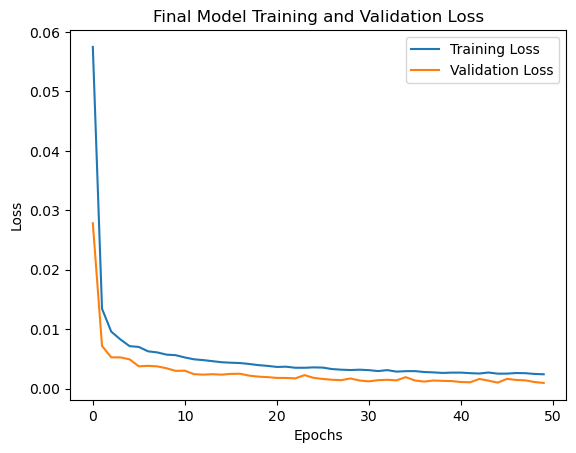

In [26]:
# Training and validation loss plot
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Final Model Training and Validation Loss')
plt.show()


#### 8.0 Evaluating the Best Model

In [27]:
# Evaluating the final model on the test set
test_loss_final = final_model.evaluate(X_test, y_test, verbose=1)

# Predictions on the test set
final_pred = final_model.predict(X_test)

final_test_mse = mean_squared_error(y_test, final_pred)
final_test_mape = mean_absolute_percentage_error(y_test, final_pred)

print(f"Final Model Test Loss: {test_loss_final:.5f}")
print(f"Final Model MSE: {final_test_mse:.5f}")
print(f"Final Model Test MAPE: {final_test_mape:.5f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Final Model Test Loss: 0.00138
Final Model MSE: 0.00099
Final Model Test MAPE: 0.07835


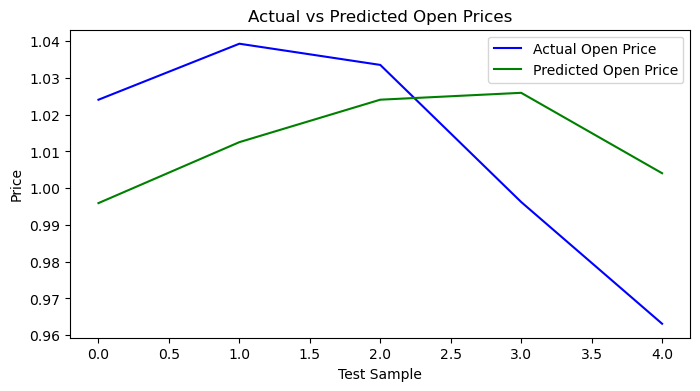

In [28]:
# Plot actual vs. predicted for Open prices
plt.figure(figsize=(8, 4))
plt.plot(y_test[:, 0], label='Actual Open Price', color='blue')
plt.plot(final_pred[:, 0], label='Predicted Open Price', color='green')
plt.title('Actual vs Predicted Open Prices')
plt.xlabel('Test Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

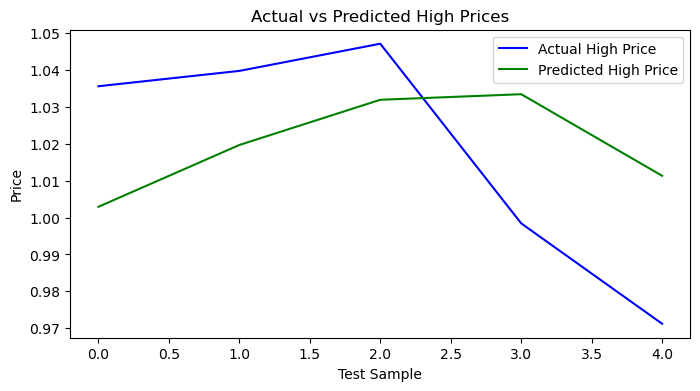

In [29]:
# Plot for High prices
plt.figure(figsize=(8, 4))
plt.plot(y_test[:, 1], label='Actual High Price', color='blue')
plt.plot(final_pred[:, 1], label='Predicted High Price', color='green')
plt.title('Actual vs Predicted High Prices')
plt.xlabel('Test Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

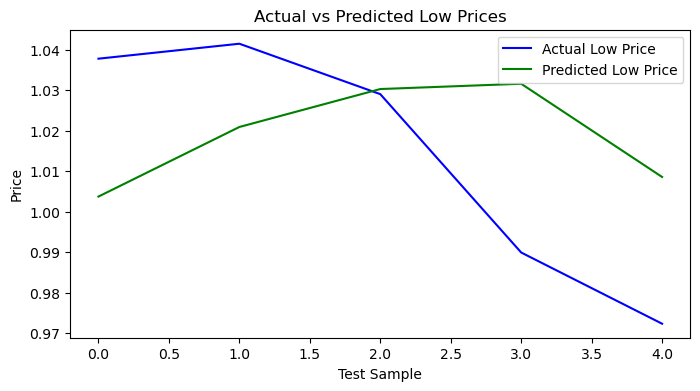

In [30]:
# Plot for Low prices
plt.figure(figsize=(8, 4))
plt.plot(y_test[:, 2], label='Actual Low Price', color='blue')
plt.plot(final_pred[:, 2], label='Predicted Low Price', color='green')
plt.title('Actual vs Predicted Low Prices')
plt.xlabel('Test Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

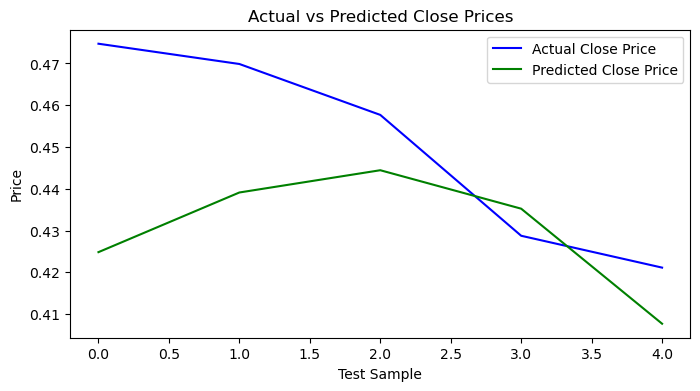

In [31]:
# Plot for Close prices
plt.figure(figsize=(8, 4))
plt.plot(y_test[:, 3], label='Actual Close Price', color='blue')
plt.plot(final_pred[:, 3], label='Predicted Close Price', color='green')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Test Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

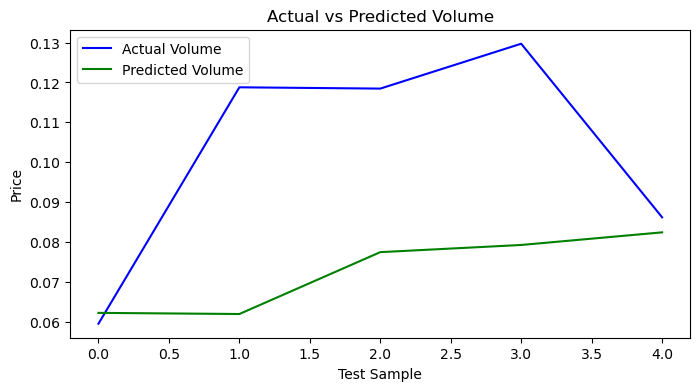

In [32]:
# Plot for Volume
plt.figure(figsize=(8, 4))
plt.plot(y_test[:, 4], label='Actual Volume', color='blue')
plt.plot(final_pred[:, 4], label='Predicted Volume', color='green')
plt.title('Actual vs Predicted Volume')
plt.xlabel('Test Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

#### 9.0 Test Case: Predicting the Next Day Stock Price

In [33]:
# Extracting the last 15 days of scaled test data
last_15_days = scaled_test_set[-15:]

# Reshaping to match the model's input shape (1, 15, 5)
input_data = last_15_days[np.newaxis, ...] # Reference: https://stackoverflow.com/questions/29241056/how-do-i-use-np-newaxis

# Inverse transformation of last 15 days to get baclk original prices
last_15_days_original = scaler.inverse_transform(last_15_days)[:, :5]

# Last 15 days' actual prices
print("Last 15 Days Prices (Open, High, Low, Close, Volume):")
for i, prices in enumerate(last_15_days_original, start=1):
    print(f"Day {i}: Open={prices[0]:.2f}, High={prices[1]:.2f}, Low={prices[2]:.2f}, Close={prices[3]:.2f}, Volume={prices[4]:.2f}")


Last 15 Days Prices (Open, High, Low, Close, Volume):
Day 1: Open=807.86, High=809.13, Low=803.51, Close=804.79, Volume=1176800.00
Day 2: Open=805.00, High=808.15, Low=801.37, Close=807.91, Volume=1065900.00
Day 3: Open=807.14, High=807.39, Low=799.17, Close=806.36, Volume=1353100.00
Day 4: Open=807.48, High=811.22, Low=806.69, Close=807.88, Volume=1099200.00
Day 5: Open=807.08, High=807.14, Low=800.37, Close=804.61, Volume=1362100.00
Day 6: Open=805.81, High=806.21, Low=800.99, Close=806.07, Volume=1294400.00
Day 7: Open=805.12, High=809.48, Low=801.80, Close=802.17, Volume=919300.00
Day 8: Open=806.91, High=806.91, Low=801.69, Close=805.02, Volume=1670000.00
Day 9: Open=807.25, High=820.87, Low=803.74, Close=819.31, Volume=1963600.00
Day 10: Open=822.30, High=825.90, Low=817.82, Close=823.87, Volume=1474000.00
Day 11: Open=829.62, High=835.77, Low=825.06, Close=835.67, Volume=1494500.00
Day 12: Open=837.81, High=838.00, Low=827.01, Close=832.15, Volume=2973900.00
Day 13: Open=834.71,

In [34]:
# Predicting the next day's stock prices
predicted_scaled = final_model.predict(input_data)


# Inverse transform to get the predicted prices
predicted_prices = scaler.inverse_transform(predicted_scaled)[:, :5]

# Print the predicted next day prices
print("\nPredicted Next Day Prices (Open, High, Low, Close):\n")
print(f"Open={predicted_prices[0, 0]:.2f}, High={predicted_prices[0, 1]:.2f}, Low={predicted_prices[0, 2]:.2f}, Close={predicted_prices[0, 3]:.2f}, Volume ={predicted_prices[0, 4]:.2f} ")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step

Predicted Next Day Prices (Open, High, Low, Close):

Open=803.60, High=807.03, Low=795.10, Close=770.80, Volume =1790388.62 


#### 10.0 Visualising the Stock Price and Volume and Next Day Predictions

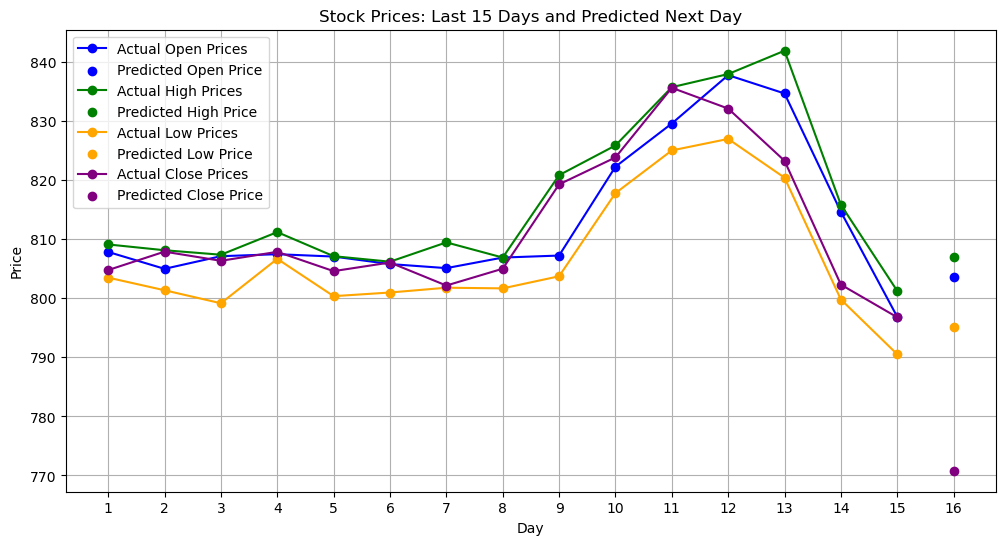

In [35]:
days = list(range(1, 16))  # Days 1 to 15
predicted_day = 16  # The next day after the 15 actual days
features = ['Open', 'High', 'Low', 'Close']
colors = ['blue', 'green', 'orange', 'purple']

plt.figure(figsize=(12, 6))

for i, feature in enumerate(features):
    # Plot actual prices for each feature
    plt.plot(days, last_15_days_original[:, i], label=f'Actual {feature} Prices', marker='o', color=colors[i])
    # Plot predicted price for each feature
    plt.scatter([predicted_day], [predicted_prices[0, i]], color=colors[i], label=f'Predicted {feature} Price', zorder=5)


plt.title('Stock Prices: Last 15 Days and Predicted Next Day')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(list(range(1, 17)))
plt.show()


##### Predicting Volume

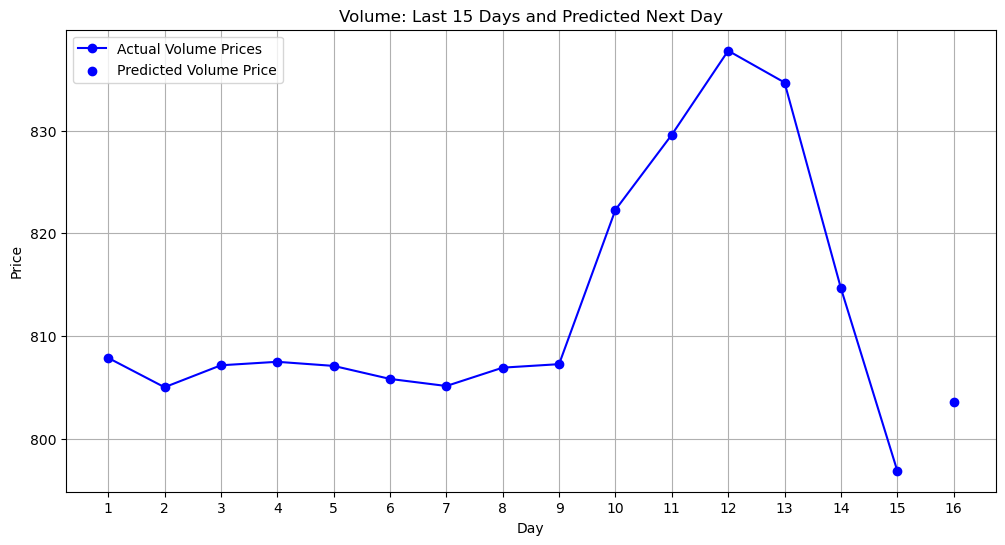

In [36]:
days = list(range(1, 16))  # Days 1 to 15
predicted_day = 16  # The next day after the 15 actual days
features = ['Volume']
colors = ['blue']

plt.figure(figsize=(12, 6))

for i, feature in enumerate(features):
    # Plot actual prices for each feature
    plt.plot(days, last_15_days_original[:, i], label=f'Actual {feature} Prices', marker='o', color=colors[i])
    # Plot predicted price for each feature
    plt.scatter([predicted_day], [predicted_prices[0, i]], color=colors[i], label=f'Predicted {feature} Price', zorder=5)


plt.title('Volume: Last 15 Days and Predicted Next Day')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(list(range(1, 17)))
plt.show()


*I acknowledge the use of python libraries, internet sources and gpt to understand and impletemnt the assignment*